# RNA-ATAC: scButterfly-T

The following tutorial demonstrate how to use scButterfly-T variant with data augmentation using cell-type labels. 

scButterfly-T with cell-type labels data augmentation will generate synthetic paired data by randomly paired scRNA-seq and scATAC-seq of different cells with the same cell type. The supplement of these generated data will provide scButterfly-T a better performance of translation, but take more time for training.

<div class="alert note">
<p>

**Note**

Most of this tutorial is same as [scButterfly-B](RNA_ATAC_paired_scButterfly-B.ipynb) with more details of data pre-processing, model constructing, model training and evaluating. It's prefered to see that first, because it has no different in parts mentioned above, but have more useful notes.


</p>
</div>

In [1]:
from scButterfly.butterfly import Butterfly
import scanpy as sc

In [2]:
butterfly = Butterfly()

In [3]:
RNA_data = sc.read_h5ad('cellline_RNA_data.h5ad')
ATAC_data = sc.read_h5ad('cellline_ATAC_data.h5ad')

In [4]:
RNA_data

AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

In [5]:
ATAC_data

AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'

In [6]:
from scButterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[4]

In [7]:
butterfly.load_data(RNA_data, ATAC_data, train_id, test_id, validation_id)

[INFO] Butterfly: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 549 × 49059
    obs: 'batch', 'cell_type'

ATAC data:
AnnData object with n_obs × n_vars = 549 × 157358
    obs: 'batch', 'cell_type'
    var: 'chrom'


In [8]:
butterfly.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] ATAC preprocessing: binarizing data.
[INFO] ATAC preprocessing: filter out peaks appear lower than 0.5% cells.
[INFO] ATAC preprocessing: TF-IDF transformation.
[INFO] ATAC preprocessing: normalizing data.


In [9]:
butterfly.ATAC_data_p.var.chrom

chr1_10292_10791            chr1
chr1_713838_714337          chr1
chr1_762665_763164          chr1
chr1_778116_778615          chr1
chr1_805064_805563          chr1
                            ... 
chr9_140916730_140917229    chr9
chr9_140947829_140948328    chr9
chr9_140948839_140949338    chr9
chr9_140960343_140960842    chr9
chr9_140995395_140995894    chr9
Name: chrom, Length: 157358, dtype: category
Categories (22, object): ['chr1', 'chr2', 'chr3', 'chr4', ..., 'chr19', 'chr20', 'chr21', 'chr22']

In [10]:
chrom_list = []
last_one = ''
for i in range(len(butterfly.ATAC_data_p.var.chrom)):
    temp = butterfly.ATAC_data_p.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[16272, 7430, 8797, 7922, 2823, 4194, 4451, 7697, 8746, 2602, 6184, 11059, 4589, 1869, 5247, 9248, 6085, 9806, 8592, 8434, 8448, 6863]

In [11]:
sum(chrom_list)

157358

## Data augmentation with cell-type labels

Here we choose the parameter ``amp_type="cell_type_augmentation"``, and scButterfly-T will automatically generate randomly paired data as supplement for training.

In [12]:
butterfly.augmentation(aug_type="cell_type_augmentation")

[INFO] Butterfly: using data amplification with cell type labels.


<div class="alert warning">
<p>

**Warning**

To use data augmentation with cell-type labels, you should ensure that there has ``cell_type`` label in ``RNA_data.obs`` and ``ATAC_data.obs``. If you try to use it without ``RNA_data.obs[cell_type]`` or ``ATAC_data.obs[cell_type]``, scButterfly will switch to data [scButterfly-C](RNA_ATAC_paired_scButterfly-C.ipynb).

</p>
</div>

In [13]:
butterfly.construct_model(chrom_list=chrom_list)

[INFO] Butterfly: successfully construct butterfly model.


Data augmentation will take more time for training.

In [14]:
butterfly.train_model()

[INFO] Butterfly: training butterfly model ...
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [03:06<00:00,  1.86s/it, train=0.4460, val=0.3914]
[INFO] Trainer: ATAC pretraining ...
ATAC pretrain: 100%|████████████████████| 100/100 [03:54<00:00,  2.35s/it, train=0.2360, val=0.2358]
[INFO] Trainer: Combine training ...
Combine training: 100%|█████████████████| 200/200 [10:27<00:00,  3.14s/it, train=1.1131, val=0.8624]


In [15]:
A2R_predict, R2A_predict = butterfly.test_model()

[INFO] Butterfly: testing butterfly model ...
[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]
[INFO] Tester: calculate neighbors graph for following test ...


In [16]:
from scButterfly.calculate_cluster import calculate_cluster_index

scButterfly-T usually get a better performance compare to [scButterfly-B](RNA_ATAC_paired_scButterfly-B.ipynb) and [scButterfly-C](RNA_ATAC_paired_scButterfly-C.ipynb).

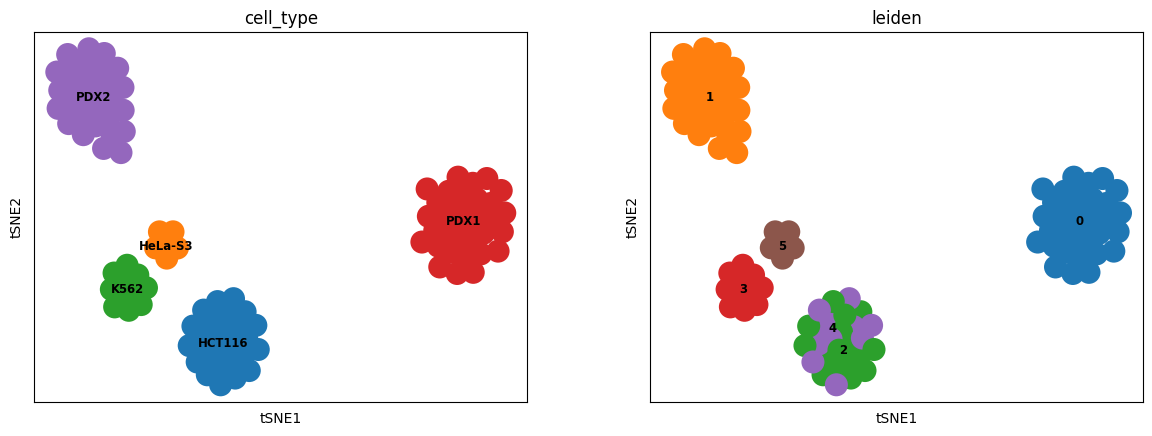

In [17]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [18]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ATAC to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ATAC to RNA:
ARI: 0.916, 	AMI: 0.942, 	NMI: 0.946, 	HOM: 1.000, 	COM: 0.897


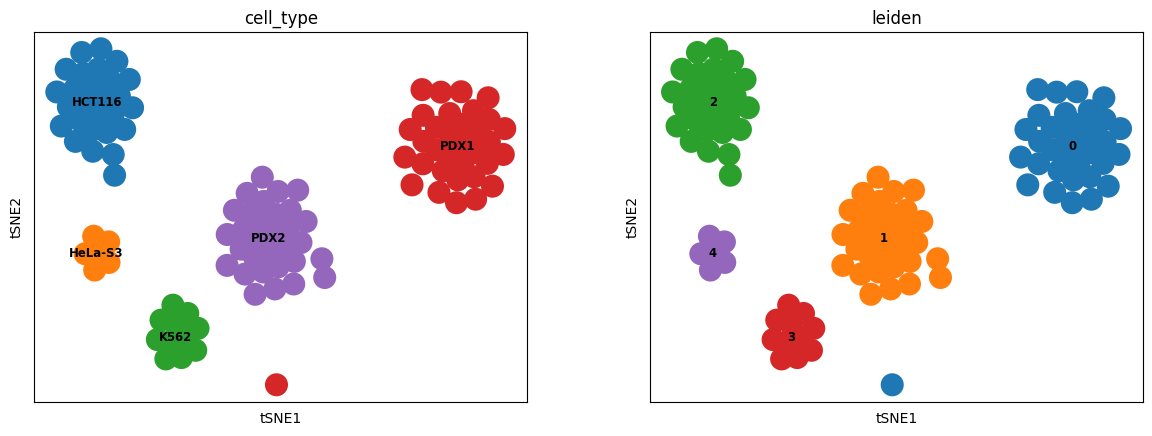

In [19]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [20]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ATAC:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ATAC:
ARI: 1.000, 	AMI: 1.000, 	NMI: 1.000, 	HOM: 1.000, 	COM: 1.000
